# Signature-Based Two Sample Hypothesis Testing

## Scaled Brownian Motion - Randomised Signature Kernels

### Andrew Alden

### Table of Contents

- [Initial Setup](#initial-setup)
- [Level Contributions](#lvl)
    - [Exp(1)](#lvl-exp)
    - [Beta(0, 0.5)](#lvl-beta)
- [Signal-to-Noise Ratio](#sr)
    - [Exp(1)](#sr-exp)
    - [Beta(0, 0.5)](#sr-beta)
- [Two-Sample Hypothesis Test](#test)
    - [Exp(1)](#test-exp)
    - [Beta(0, 0.5)](#test-beta)

## Initial Setup <a class="anchor" id="initial-setup"></a>

### Change working directory to root folder

In [2]:
import os
os.getcwd()
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

### Import libraries 

In [ ]:
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.special import gamma

from src.utils.plotting_functions import plot_dist, plot_dist_boxen


from src.mmd.distribution_functions import return_mmd_distributions, get_level_values
from src.mmd.mmd import SigKernel, LinearKernel

from src.StochasticProcesses.ScaledBM import generate_scaled_brownian_motion_paths


### Set device

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


### Set Stochastic Processes

In [4]:
sig = 0.25
beta = 0.35

T           = 1
grid_points = 32

path_bank_size = 32768
state_size     = 1
    
h0_paths = torch.transpose(torch.from_numpy(generate_scaled_brownian_motion_paths(0.0, sig, path_bank_size, grid_points, T)), 0, 1).to(device=device)
h1_paths = torch.transpose(torch.from_numpy(generate_scaled_brownian_motion_paths(0.0, beta, path_bank_size, grid_points, T)), 0, 1).to(device=device)

## Level Contributions <a class="anchor" id="lvl"></a>

In [47]:
sig = 0.25
beta = 0.35

ks = [1, 2, 3, 4, 5, 6]

n_atoms = 1000
n_paths = 128

h0_Mk_vals, h1_Mk_vals = get_level_values(torch.multiply(torch.Tensor([1, 1]).to(device=device), h0_paths[:, :, :]), 
                                          torch.multiply(torch.Tensor([1, 1]).to(device=device), h1_paths[:, :, :]), 
                                          n_atoms, n_paths, ks, path_bank_size)
h0_Mk_vals = np.asarray(h0_Mk_vals)
h1_Mk_vals = np.asarray(h1_Mk_vals)

100%|██████████| 1000/1000 [01:35<00:00, 10.43it/s]


In [48]:
h0_Mk_vals_exp = np.zeros(h0_Mk_vals.shape)
h1_Mk_vals_exp = np.zeros(h0_Mk_vals.shape)

h0_Mk_vals_gamma = np.zeros(h0_Mk_vals.shape)
h1_Mk_vals_gamma = np.zeros(h0_Mk_vals.shape)
b = 0.5
for i in range(6):
    h0_Mk_vals_exp[i, ...] = gamma((i+1)/2) * h0_Mk_vals[i, ...]
    h1_Mk_vals_exp[i, ...] = gamma((i+1)/2) * h1_Mk_vals[i, ...]
    
    h0_Mk_vals_gamma[i, ...] = gamma(b+1) * gamma(i+2) * 1/gamma(b+i+2) * h0_Mk_vals[i, ...]
    h1_Mk_vals_gamma[i, ...] = gamma(b+1) * gamma(i+2) * 1/gamma(b+i+2)  * h1_Mk_vals[i, ...]

### Exp(1) <a class="anchor" id="lvl-exp"></a>

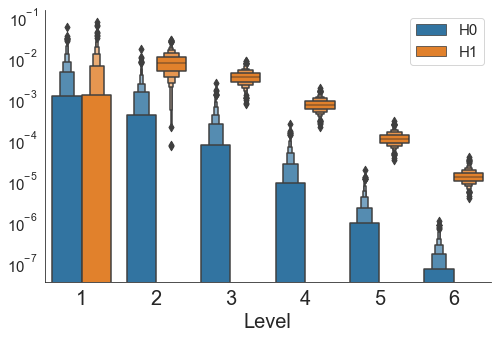

In [56]:
df_scaling = pd.DataFrame({'H': ['H0' for _ in range(n_atoms * len(ks))] + ['H1' for _ in range(n_atoms * len(ks))], 'Level': np.tile(np.asarray([[i for _ in range(n_atoms)] for i in ks]).flatten(), 2), 'MMD': np.concatenate((h0_Mk_vals_exp.flatten(), h1_Mk_vals_exp.flatten()))})
plot_dist_boxen(df_scaling, 'Level', 'MMD', hue='H', x_label='Level', filename=f'ScaledBMImages/scaledbm_level_contrib_exp_random.svg', svg=True, log_scale=True)

### Beta (0, 0.5) <a class="anchor" id="lvl-beta"></a>

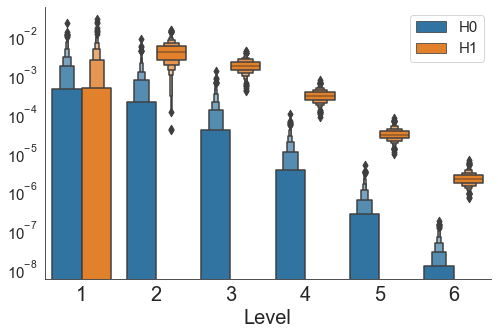

In [61]:
df_scaling = pd.DataFrame({'H': ['H0' for _ in range(n_atoms * len(ks))] + ['H1' for _ in range(n_atoms * len(ks))], 'Level': np.tile(np.asarray([[i for _ in range(n_atoms)] for i in ks]).flatten(), 2), 'MMD': np.concatenate((h0_Mk_vals_gamma.flatten(), h1_Mk_vals_gamma.flatten()))})
plot_dist_boxen(df_scaling, 'Level', 'MMD', hue='H', x_label='Level', filename=f'ScaledBMImages/scaledbm_level_contrib_beta_random_05.svg', svg=True, log_scale=True)

## Signal-to-Noise Ratio <a class="anchor" id="sr"></a>

In [8]:
n_atoms = 1000
ks = [1, 2, 3, 4, 5, 6]


h0_Mk_vals_sr_global_scaling = np.zeros((6, len(ks), n_atoms))
h1_Mk_vals_sr_global_scaling = np.zeros((6, len(ks), n_atoms))

scaling = 3.0


for i, n_paths in enumerate([32, 64, 128, 256, 512, 1000]):
    
    h0_Mk_vals_sr_scaling, h1_Mk_vals_sr_scaling = get_level_values(torch.multiply(torch.Tensor([1, 1]).to(device=device), h0_paths[:, :, :]), 
                                          torch.multiply(torch.Tensor([1, 1]).to(device=device), h1_paths[:, :, :]), 
                                          n_atoms, n_paths, ks, path_bank_size)
    h0_Mk_vals_sr_scaling = np.asarray(h0_Mk_vals_sr_scaling)
    h1_Mk_vals_sr_scaling = np.asarray(h1_Mk_vals_sr_scaling)
    
    h0_Mk_vals_sr_global_scaling[i, ...] = h0_Mk_vals_sr_scaling
    h1_Mk_vals_sr_global_scaling[i, ...] = h1_Mk_vals_sr_scaling

100%|██████████| 1000/1000 [10:19<00:00,  1.61it/s]


### Exp(1) <a class="anchor" id="sr-exp"></a>

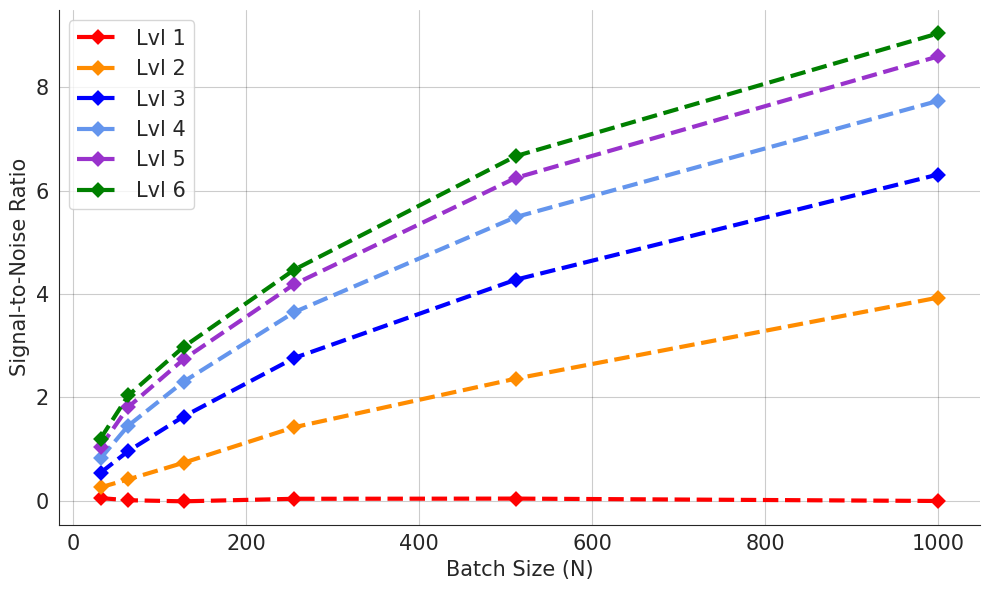

In [18]:
batch_sizes = [32, 64, 128, 256, 512, 1000]
colors = ['red', 'darkorange', 'blue', 'cornflowerblue', 'darkorchid', 'green']
fig, ax = plt.subplots(figsize=(10, 6))
for i, lvl in enumerate(ks):
    ax.plot(batch_sizes, 
               [np.mean(gamma((i+1)/2) * h1_Mk_vals_sr_global_scaling[j, i, ...])/np.std(gamma((i+1)/2) * h1_Mk_vals_sr_global_scaling[j, i, ...]) 
                for j in range(len(batch_sizes))], 
            label = f'Lvl {lvl}', 
            color=colors[i],
            marker='D',
            linestyle='--', 
            linewidth=3.0, 
            markersize=4.0, 
            markeredgewidth=4.0)
ax.legend(loc='best', fontsize=15)
ax.grid(True, color='black', alpha=0.2)
plt.setp(ax.get_xticklabels(), fontsize=15)
plt.setp(ax.get_yticklabels(), fontsize=15)
ax.set_ylabel(r"Signal-to-Noise Ratio", fontsize=15)
ax.set_xlabel("Batch Size (N)", fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

### Beta (0, 0.5) <a class="anchor" id="sr-beta"></a>

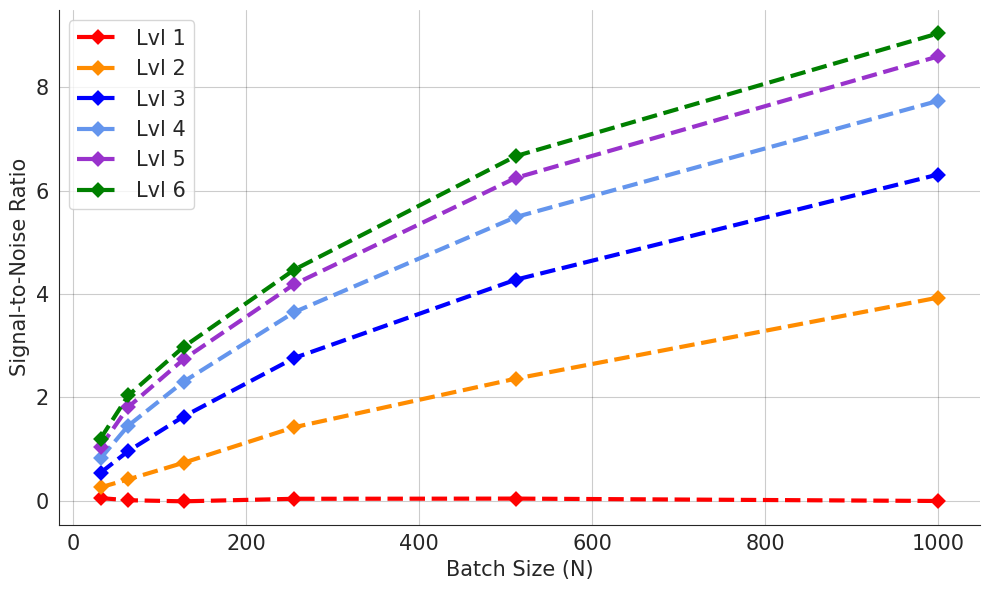

In [19]:
batch_sizes = [32, 64, 128, 256, 512, 1000]
colors = ['red', 'darkorange', 'blue', 'cornflowerblue', 'darkorchid', 'green']
fig, ax = plt.subplots(figsize=(10, 6))
b = 0.5
for i, lvl in enumerate(ks):
    ax.plot(batch_sizes, 
               [np.mean(gamma(b+1) * gamma(i+2) * 1/gamma(b+i+2) * h1_Mk_vals_sr_global_scaling[j, i, ...])/np.std(gamma(b+1) * gamma(i+2) * 1/gamma(b+i+2) * h1_Mk_vals_sr_global_scaling[j, i, ...]) 
                for j in range(len(batch_sizes))], 
            label = f'Lvl {lvl}', 
            color=colors[i],
            marker='D',
            linestyle='--', 
            linewidth=3.0, 
            markersize=4.0, 
            markeredgewidth=4.0)
ax.legend(loc='best', fontsize=15)
ax.grid(True, color='black', alpha=0.2)
plt.setp(ax.get_xticklabels(), fontsize=15)
plt.setp(ax.get_yticklabels(), fontsize=15)
ax.set_ylabel(r"Signal-to-Noise Ratio", fontsize=15)
ax.set_xlabel("Batch Size (N)", fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

## Two-Sample Hypothesis Test <a class="anchor" id="test"></a>

In [5]:
dyadic_order  = 0  
static_kernel = LinearKernel()

signature_kernel = SigKernel(static_kernel=static_kernel, dyadic_order=dyadic_order)

### Exp(1) <a class="anchor" id="test-exp"></a>

In [52]:
h0_dists_global_exp = []
h1_dists_global_exp = []
num_sim = 100
n_atoms = 500
n_paths = 128


scaling = np.power(np.random.exponential(1), 0.25)

h0_dists, h1_dists, rand_ints = return_mmd_distributions(
torch.multiply(torch.Tensor([scaling, scaling]).to(device=device), h0_paths[:, :, :]), 
torch.multiply(torch.Tensor([scaling, scaling]).to(device=device), h1_paths[:, :, :]), 
signature_kernel.compute_mmd, 
n_atoms=n_atoms, 
batch_size=n_paths, 
estimator='ub',
u_stat=False,
verbose=False
)
h0_dists_global_exp.append(h0_dists)
h1_dists_global_exp.append(h1_dists)

for _ in tqdm(range(num_sim-1)):

    scaling = np.power(np.random.exponential(1), 0.25)
    
    h0_dists, h1_dists, _ = return_mmd_distributions(
    torch.multiply(torch.Tensor([scaling, scaling]).to(device=device), h0_paths[:, :, :]), 
    torch.multiply(torch.Tensor([scaling, scaling]).to(device=device), h1_paths[:, :, :]), 
    signature_kernel.compute_mmd, 
    n_atoms=n_atoms, 
    batch_size=n_paths, 
    estimator='ub',
    u_stat=False,
    verbose=False,
    rand_ints=rand_ints
    )
    h0_dists_global_exp.append(h0_dists)
    h1_dists_global_exp.append(h1_dists)

100%|██████████| 99/99 [21:32<00:00, 13.05s/it]


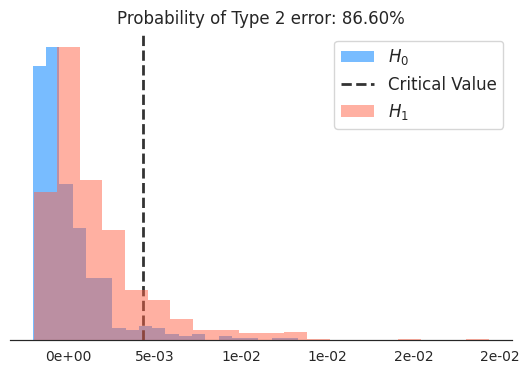

In [54]:
alpha = 0.05
plot_dist(np.mean(np.asarray(h0_dists_global_exp), axis=0), np.mean(np.asarray(h1_dists_global_exp), axis=0), n_atoms, alpha, svg=True, filename=f'ScaledBMImages/dist_scaledbm_ub_exp_random.svg', scientific=True)

### Beta(0, 0.5) <a class="anchor" id="test-beta"></a>

In [55]:
h0_dists_global = []
h1_dists_global = []
num_sim = 100
n_atoms = 500
n_paths = 128
b = 0.5

scaling = np.power(np.random.beta(1, b), 0.5)

h0_dists, h1_dists, rand_ints = return_mmd_distributions(
torch.multiply(torch.Tensor([scaling, scaling]).to(device=device), h0_paths[:, :, :]), 
torch.multiply(torch.Tensor([scaling, scaling]).to(device=device), h1_paths[:, :, :]), 
signature_kernel.compute_mmd, 
n_atoms=n_atoms, 
batch_size=n_paths, 
estimator='ub',
u_stat=False,
verbose=False
)

h0_dists_global.append(h0_dists)
h1_dists_global.append(h1_dists)

for _ in tqdm(range(num_sim-1)):

    scaling = np.power(np.random.beta(1, b), 0.5)
    
    h0_dists, h1_dists, _ = return_mmd_distributions(
    torch.multiply(torch.Tensor([scaling, scaling]).to(device=device), h0_paths[:, :, :]), 
    torch.multiply(torch.Tensor([scaling, scaling]).to(device=device), h1_paths[:, :, :]), 
    signature_kernel.compute_mmd, 
    n_atoms=n_atoms, 
    batch_size=n_paths, 
    estimator='ub',
    u_stat=False,
    verbose=False, 
    rand_ints=rand_ints
    )
    h0_dists_global.append(h0_dists)
    h1_dists_global.append(h1_dists)

100%|██████████| 99/99 [21:32<00:00, 13.05s/it]


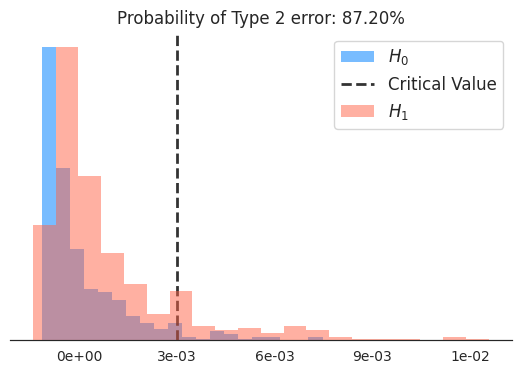

In [56]:
alpha = 0.05
plot_dist(np.mean(np.asarray(h0_dists_global), axis=0), np.mean(np.asarray(h1_dists_global), axis=0), n_atoms, alpha, svg=True, filename=f'ScaledBMImages/dist_scaledbm_ub_beta_random_05.svg', scientific=True)